In [ ]:
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
import sys
from lime.lime_tabular import LimeTabularExplainer
import shap
import matplotlib.pyplot as plt
path='your/path/before/islbbnn/folder'
os.chdir(path)
current_dir = os.getcwd()
sys.path.append('islbbnn')
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('islbbnn/networks')
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

In [2]:
device = torch.device("cpu")

In [3]:
current_dir

'/home/eirik/projects/Interpretable-NNs'

In [4]:
net = torch.load('lrt_implementation/network/net7_non_linear', weights_only=False).to(device)
net.eval()

BayesianNetwork(
  (linears): ModuleList(
    (0-4): 5 x BayesianLinear()
  )
  (loss): BCELoss()
)

In [ ]:
net = torch.load('lrt_implementation/network/net9_linear', weights_only=False).to(device)
net.eval()

BayesianNetwork(
  (linears): ModuleList(
    (0-4): 5 x BayesianLinear()
  )
  (loss): BCELoss()
)

In [5]:
# Get linear data
y, X = pip_func.create_data_unif(100, beta=[100,1,1,1,1], dep_level=0.0, classification=True, non_lin=True)

data = torch.tensor(np.column_stack((X,y)),dtype = torch.float32)

p = X.shape[1]

In [6]:
for i in range(100):
    # if np.sign(X[i,1]) != np.sign(X[i,2]):
    if abs(X[i,1] + X[i,2]) < 0.5:
        # if abs(X[i,1]) > 2 and abs(X[i,2]) > 2:
        print(i)
        print(X[i])

62
[ 1.         -8.80548703  8.35781581  7.76060301 -4.42553422]
69
[ 1.          3.70525651 -3.59902676  9.69212256  8.23398882]
91
[ 1.         -4.57312597  4.44525643  6.76158957 -5.12971422]
97
[ 1.          5.24007175 -5.06459702  8.62477801 -2.37749392]


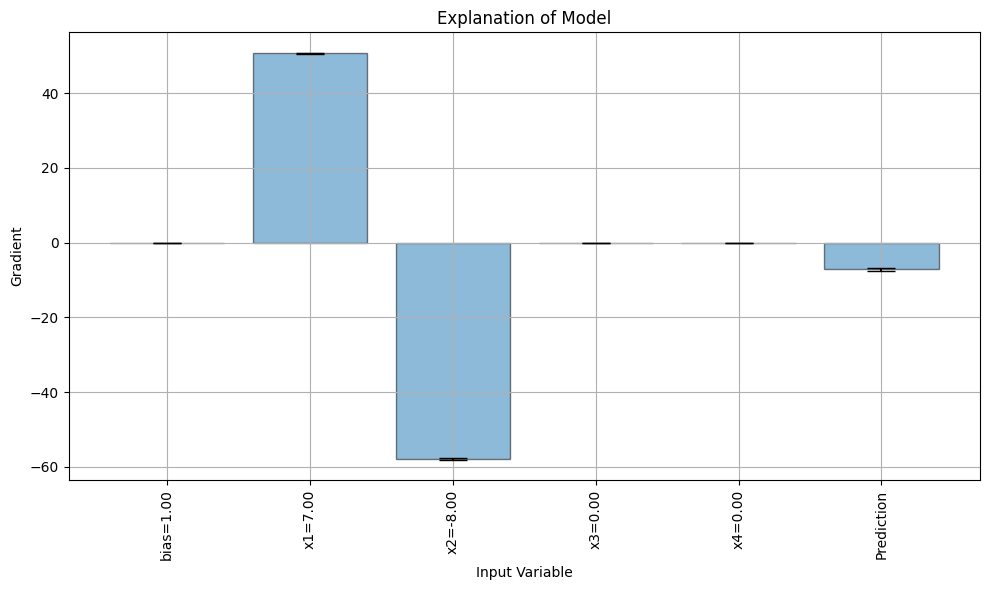

In [48]:
include_potential_contribution = True
i = 62
n_samples = 1_000
explanation = torch.zeros((n_samples,p))
preds = torch.zeros((n_samples,1))
for j in range(n_samples):
    
    # explain_this = data[i,:-1].reshape(-1, p).to(device)
    explain_this = torch.tensor([[1.000, 7.00, -8.00, 0.0, 0.0]]).to(device)
    explain_this.requires_grad = True
    net.zero_grad()
    output = net.forward_preact(explain_this, sample=True, ensemble=not True)
    output_value = output[0,0]
    output_value.backward()

    gradients = explain_this.grad
    explanation[j] = gradients[0]
    preds[j,0] = output[0,0]

expl = explanation.cpu().detach().numpy()
if include_potential_contribution:
    expl = np.where(explain_this != 0.0, expl, -expl)    
# remove variables that does not contribute to the prediction at all
else:
    expl = np.where(explain_this != 0.0, expl, 0)

magnitude = False
if not magnitude:
    expl = expl*explain_this.cpu().detach().numpy()
# expl = explanation.cpu().detach().numpy()
expl = np.concatenate((expl, preds.cpu().detach().numpy()),1)
means = expl.mean(0)

variable_names = ["bias","x1","x2","x3","x4"]
for i, v in enumerate(variable_names):
    variable_names[i] = v + f"={explain_this[0,i].cpu().detach().numpy():.2f}"

variable_names.append("Prediction")


cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
plt.figure(figsize=(10, 6))
plt.bar(range(p+1), means, yerr=(bottom, top), align='center', alpha=0.5, edgecolor='k', capsize=10)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(p+1), [f'{variable_names[i]}' for i in range(p+1)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

In [13]:
k=torch.tensor([1.000, 7.00, -8.00, 0.0, 0.0])
k[:-1].shape

torch.Size([4])

In [108]:
import importlib
importlib.reload(pip_func)
importlib.reload(pf)

<module 'plot_functions' from '/home/eirik/projects/Interpretable-NNs/islbbnn/plot_functions.py'>

In [170]:
sns.reset_orig()
plt.clf()
plt.close()

In [180]:
net = torch.load('lrt_implementation/network/net9_linear', weights_only=False).to(device)
net.eval()

BayesianNetwork(
  (linears): ModuleList(
    (0-4): 5 x BayesianLinear()
  )
  (loss): BCELoss()
)

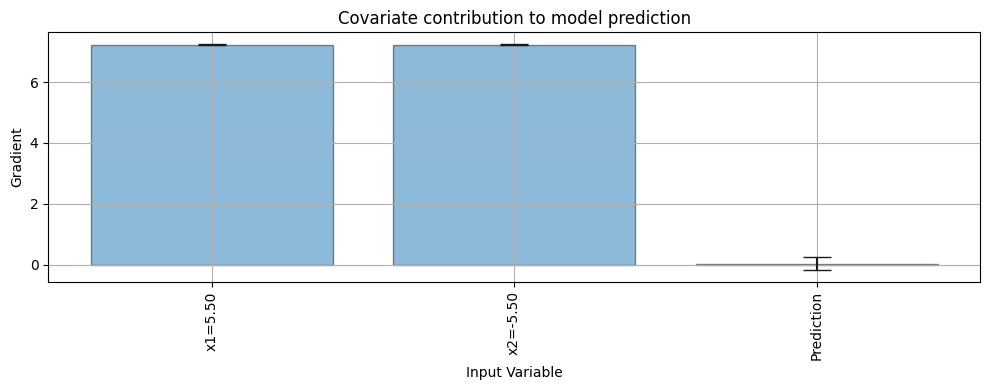

In [182]:
pf.plot_local_explain_piecewise_linear_act(net, torch.tensor([1.000, 5.50, -5.50, 10.0, -50.0]), n_samples=1000, magnitude=True, include_prediction=True, include_bias=True, fig_size=(10,4), no_zero_contributions=True, save_path="lrt_implementation/local_contributions/imgs/local_contribution_linear.png")

In [183]:
net = torch.load('lrt_implementation/network/net7_non_linear', weights_only=False).to(device)
net.eval()

BayesianNetwork(
  (linears): ModuleList(
    (0-4): 5 x BayesianLinear()
  )
  (loss): BCELoss()
)

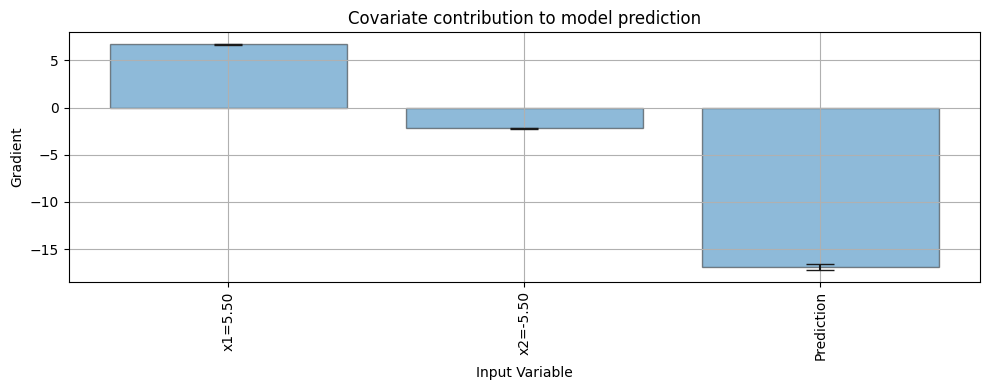

In [184]:
pf.plot_local_explain_piecewise_linear_act(net, torch.tensor([1.000, 5.50, -5.50, 10.0, -50.0]), n_samples=1000, magnitude=True, include_prediction=True, include_bias=False, fig_size=(10,4), no_zero_contributions=True, save_path="lrt_implementation/local_contributions/imgs/local_contribution_non_linear.png")

In [52]:
100*100

10000

In [60]:
np.unique(np.where(contributions[1] == 0)[1])

array([0, 3, 4])

In [157]:
net = torch.load('lrt_implementation/network/net9_linear', weights_only=False).to(device)
net.eval()

BayesianNetwork(
  (linears): ModuleList(
    (0-4): 5 x BayesianLinear()
  )
  (loss): BCELoss()
)

In [158]:
y, X = pip_func.create_data_unif(100, beta=[100,1,1,1,1], dep_level=0.0, classification=True, non_lin=True)

data = torch.tensor(X,dtype = torch.float32)

contributions_lin = np.zeros((len(X), 100, 5))

for ind, d in enumerate(data):
    expl, _, _ = pip_func.local_explain_piecewise_linear_act(net, d, n_samples=100)
    contributions_lin[ind] = expl

In [165]:
current_dir

'/home/eirik/projects/Interpretable-NNs'

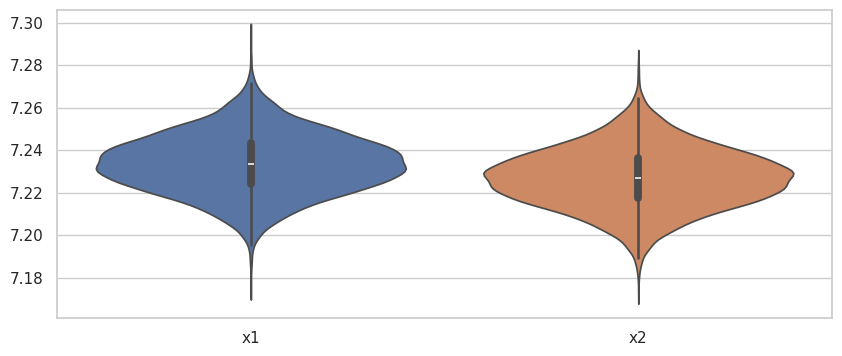

In [166]:
df = pd.DataFrame(contributions_lin.reshape(100*100,-1), columns=["x0","x1","x2","x3","x4"])
plt.figure(figsize=(10,4))
sns.violinplot(df.iloc[:,[1,2]])
plt.savefig("lrt_implementation/local_contributions/imgs/global_explain_linear.png")
plt.show()

In [138]:
net = torch.load('lrt_implementation/network/net7_non_linear', weights_only=False).to(device)
net.eval()

BayesianNetwork(
  (linears): ModuleList(
    (0-4): 5 x BayesianLinear()
  )
  (loss): BCELoss()
)

In [139]:
y, X = pip_func.create_data_unif(1000, beta=[100,1,1,1,1], dep_level=0.0, classification=True, non_lin=True)

data = torch.tensor(X,dtype = torch.float32)

contributions_non_lin = np.zeros((len(X), 100, 5))

for ind, d in enumerate(data):
    expl, _, _ = pip_func.local_explain_piecewise_linear_act(net, d, n_samples=100)
    contributions_non_lin[ind] = expl

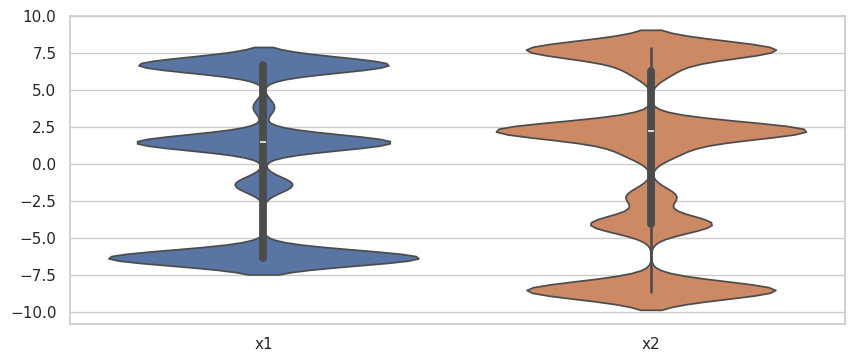

In [167]:
df = pd.DataFrame(contributions_non_lin.reshape(1000*100,-1), columns=["x0","x1","x2","x3","x4"])
plt.figure(figsize=(10,4))
sns.set(style="whitegrid")
sns.violinplot(df.iloc[:,[1,2]])
plt.savefig("lrt_implementation/local_contributions/imgs/global_explain_non_linear.png")
plt.show()

In [54]:
contributions

array([[[0.        , 7.21599436, 7.21853352, 0.        , 0.        ],
        [0.        , 7.24085951, 7.2228756 , 0.        , 0.        ],
        [0.        , 7.23493862, 7.24101305, 0.        , 0.        ],
        ...,
        [0.        , 7.21935511, 7.21374989, 0.        , 0.        ],
        [0.        , 7.22766924, 7.23874521, 0.        , 0.        ],
        [0.        , 7.23274994, 7.22771883, 0.        , 0.        ]],

       [[0.        , 7.24449396, 7.22017908, 0.        , 0.        ],
        [0.        , 7.21926594, 7.20990276, 0.        , 0.        ],
        [0.        , 7.22609234, 7.22992516, 0.        , 0.        ],
        ...,
        [0.        , 7.21469975, 7.22805023, 0.        , 0.        ],
        [0.        , 7.24750757, 7.23855114, 0.        , 0.        ],
        [0.        , 7.21064663, 7.20616102, 0.        , 0.        ]],

       [[0.        , 7.22003937, 7.22817564, 0.        , 0.        ],
        [0.        , 7.22385645, 7.23842525, 0.        , 0. 

In [68]:
preds

tensor([[6.9358],
        [6.9238],
        [6.9424],
        [6.9370],
        [6.9341],
        [6.9341],
        [6.9451],
        [6.9295],
        [6.9170],
        [6.9238]], grad_fn=<CopySlices>)

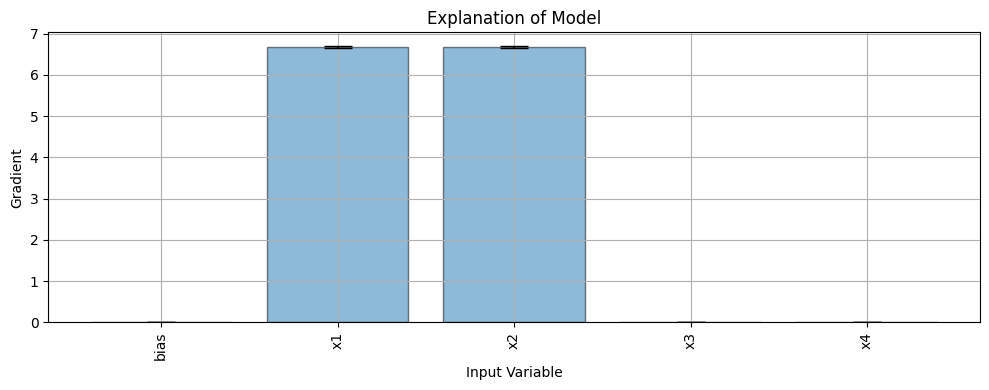

In [28]:
# remove variables that does not contribute to the prediction at all
expl = np.where(explain_this[0].cpu().detach().numpy() != 0.0, explanation.cpu().detach().numpy(), 0)
means = expl.mean(0)

cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
plt.figure(figsize=(10, 4))
plt.bar(range(p), means, yerr=(bottom, top), align='center', alpha=0.5, edgecolor='k', capsize=10)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(p), [f'{variable_names[i]}' for i in range(p)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

In [103]:
pip_func.weight_matrices_std_numpy(net)[-1]

array([[0.02188887, 0.01512943, 0.01187757, 0.01503273, 0.01555743,
        0.01561086, 0.01515844, 0.01552953, 0.0159459 , 0.01547191,
        0.01571276, 0.02574414, 0.01545535, 0.01517179, 0.01525578,
        0.01593553, 0.01582979, 0.01553596, 0.0154198 , 0.01566172,
        0.04404695, 0.00729938, 0.00764143, 0.00755654, 0.00757098]],
      dtype=float32)

In [9]:
data

tensor([[ 1.0000e+00,  3.4732e+00, -5.7612e+00,  3.0403e-01, -5.9971e+00,
          0.0000e+00],
        [ 1.0000e+00,  6.1607e+00, -7.3755e+00, -3.7471e+00, -7.3590e+00,
          0.0000e+00],
        [ 1.0000e+00, -6.6109e+00,  1.0966e+00,  2.2818e+00,  2.0097e+00,
          0.0000e+00],
        [ 1.0000e+00, -7.5522e+00,  2.4330e+00,  6.2530e+00, -5.1050e+00,
          0.0000e+00],
        [ 1.0000e+00,  1.5693e+00, -6.7216e+00,  5.8441e+00, -5.6220e+00,
          0.0000e+00],
        [ 1.0000e+00,  4.7162e+00, -6.1125e-01, -5.6947e+00, -7.3493e+00,
          1.0000e+00],
        [ 1.0000e+00,  7.1247e+00,  4.6606e+00,  4.5534e+00,  9.3518e+00,
          1.0000e+00],
        [ 1.0000e+00,  2.6345e+00, -8.1055e+00, -3.4683e+00, -1.2815e+00,
          0.0000e+00],
        [ 1.0000e+00, -2.0156e+00, -6.7387e+00,  9.7308e-01, -8.6160e+00,
          0.0000e+00],
        [ 1.0000e+00, -8.3537e+00, -9.8720e+00,  6.9756e+00,  9.8414e+00,
          0.0000e+00],
        [ 1.0000e+00, -8.4802e

## LIME and SHAP code

Used to compare the methods.

### LIME

In [ ]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_lime(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    if len(x.shape) == 1:
        preds = np.zeros((1000, 1, 1))
    else:
        preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
            # preds[samp, :, 0] = 1 - preds[samp, :, 1]
    preds = preds.mean(0)
    return preds

def explain_lime(indx, X_test, feature_names=variable_names, class_names=["rings"]):
    # Assuming `X_train` is your training data and `class_names` are the names of the classes
    explainer = LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='regression'
    )
    # Explain a single instance
    exp = explainer.explain_instance(
        data_row=X_test[indx],
        predict_fn=batch_predict_lime,
        num_features=len(variable_names),  # Number of features to include in the explanation
        num_samples=2_000
    )
    return exp


def plot_lime_explain(exp, indx, class_label=1, names_features=variable_names):
    # Extract feature importances for a specific class
    feature_importances = dict(exp.as_map()[class_label])

    # Ensure the feature importances are in the correct order
    ordered_importances = [feature_importances[indx] for indx in range(len(names_features))]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(names_features, ordered_importances, color='skyblue', edgecolor='k')
    plt.ylabel('LIME importance')
    plt.xlabel('Feature')
    plt.title(f'LIME feature importances for Class {class_label} (instance {indx})')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

### SHAP

In [ ]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_shap(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
    preds = preds.mean(0)
    return preds


def shap_explain(X_test, i):
    # Create SHAP explainer
    explainer = shap.Explainer(batch_predict_shap, X_train)
    # Index of the instance you want to explain

    # Explain the instance
    shap_vals = explainer(X_test[i:i+1], max_evals=1_000, batch_size=256)
    return shap_vals

def plot_shap_explain(shap_vals, i, feature_names = variable_names):
    # Plot bar plot of SHAP values
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, shap_vals.values[0], color='skyblue', edgecolor='k')
    plt.xlabel('Feature')
    plt.ylabel('SHAP value')
    plt.title(f'SHAP values for instance {i}. Baseline: {shap_vals.base_values[0][0]:.4f}')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

In [4]:
import numpy as np
my_list = np.array([[ 0.971  , 18.     ],
 [ 0.97825, 18.     ],
 [ 0.99425, 48.     ],
 [ 0.97825, 18.     ],
 [ 0.98225, 23.     ],
 [ 0.971  , 18.     ],
 [ 0.99175, 43.     ],
 [ 0.9805 , 19.     ],
 [ 0.9945 , 38.     ],
 [ 0.985  , 28.     ]])

In [11]:
np.median(my_list[:,0]), np.min(my_list[:,0]), np.max(my_list[:,0])

(np.float64(0.981375), np.float64(0.971), np.float64(0.9945))

In [12]:
my_list = np.array([[0.97275,    0.01107692],
 [0.97825,    0.01107692],
 [0.99425,    0.02953846],
 [0.978  ,    0.01107692],
 [0.98175,    0.01415385],
 [0.97075,    0.01107692],
 [0.992  ,    0.02646154],
 [0.98075,    0.01169231],
 [0.99375,    0.02338462],
 [0.9855,     0.01723077]])

In [13]:
np.median(my_list[:,1]), np.min(my_list[:,1]), np.max(my_list[:,1])

(np.float64(0.01292308), np.float64(0.01107692), np.float64(0.02953846))